In [15]:
import numpy as np
import torch

from torch.utils.data import DataLoader
from flytracker.io.dataset import VideoDataset, TorchVideoDataset

from flytracker.tracker import _run, _initialize, _localize
from flytracker.preprocessing.preprocessing import  preprocessing_torch
from flytracker.localization.blob import localize_blob, default_blob_detector_params
from flytracker.localization.kmeans import localize_kmeans_torch
import torch.autograd.profiler as profiler
from flytracker.tracking import tracking
from flytracker.analysis import post_process

import cProfile, pstats, io
from pstats import SortKey

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
movie_path = "../../data/experiments/bruno/videos/seq_1.mp4"


mask = torch.ones((1080, 1280), dtype=bool)
mask[:130, :] = 0
mask[-160:, :] = 0
mask[:, :270] = 0
mask[:, -205:] = 0

mask[:190, :350] = 0
mask[:195, -270:] = 0
mask[-220:, :340] = 0
mask[870:, 1010:] = 0

In [7]:
dataset = VideoDataset(movie_path)
loader = DataLoader(dataset, batch_size=None, pin_memory=True)

In [8]:
preprocessor_ini = preprocessing_torch(mask, torch.tensor(255, dtype=torch.uint8))
initial_position, initial_frame = _initialize(loader, localize_blob, (default_blob_detector_params(), preprocessor_ini), 100)

In [9]:
preprocessor_main= preprocessing_torch(mask.cuda(), torch.tensor(255, dtype=torch.uint8).cuda())

In [10]:
%%time
locations = _localize(loader, localize_kmeans_torch, (preprocessor_main, 120, 'cuda'), initial_position, 10000)

Done with frame 0
Done with frame 1000
Done with frame 2000
Done with frame 3000
Done with frame 4000
Done with frame 5000
Done with frame 6000
Done with frame 7000
Done with frame 8000
Done with frame 9000
Done with frame 10000
CPU times: user 9min 51s, sys: 9.82 s, total: 10min 1s
Wall time: 35.6 s


In [9]:
dataset = VideoDataset(movie_path)
loader = DataLoader(dataset, batch_size=None, pin_memory=True)

preprocessor_ini = preprocessing_torch(mask, torch.tensor(255, dtype=torch.uint8))
initial_position, initial_frame = _initialize(loader, localize_blob, (default_blob_detector_params(), preprocessor_ini), 100)

pr = cProfile.Profile()
pr.enable()
_localize(loader, localize_kmeans_torch, (preprocessor_main, 120, 'cuda'), initial_position, 1000)
pr.disable() 

Done with frame 0
Done with frame 1000


In [10]:
s = io.StringIO()
sortby = SortKey.CUMULATIVE
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

         134750 function calls in 3.564 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    3.564    1.782 /home/gert-jan/anaconda3/envs/updated/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3386(run_code)
        2    0.000    0.000    3.564    1.782 {built-in method builtins.exec}
        1    0.001    0.001    3.564    3.564 <ipython-input-9-35f0872798ca>:9(<module>)
        1    0.008    0.008    3.563    3.563 /home/gert-jan/Documents/flyTracker/src/flytracker/tracker.py:89(_localize)
     1002    0.002    0.000    2.028    0.002 /home/gert-jan/anaconda3/envs/updated/lib/python3.8/site-packages/torch/utils/data/dataloader.py:432(__next__)
     1002    0.004    0.000    2.026    0.002 /home/gert-jan/anaconda3/envs/updated/lib/python3.8/site-packages/torch/utils/data/dataloader.py:473(_next_data)
     1002    0.001    0.000    1.770    0.002 /home/gert-jan/anaconda3/envs/update

In [19]:
%%time
dataset = VideoDataset(movie_path)
loader = DataLoader(dataset, batch_size=None, pin_memory=True)

preprocessor_ini = preprocessing_torch(mask, torch.tensor(255, dtype=torch.uint8))
initial_position, initial_frame = _initialize(loader, localize_blob, (default_blob_detector_params(), preprocessor_ini), 100)


with profiler.profile(record_shapes=True, profile_memory=True, use_cuda=True) as prof:
    with profiler.record_function("model_training"):
        _localize(loader, localize_kmeans_torch, (preprocessor_main, 120, 'cuda'), initial_position, 100)
prof.export_chrome_trace("trace.json")    

Done with frame 0
CPU times: user 28.2 s, sys: 504 ms, total: 28.7 s
Wall time: 2.89 s


okay fuck it now that we have this done, let's try multiprocessing again:

In [ ]:
%%time
dataset = TorchVideoDataset(movie_path)
loader = DataLoader(dataset, batch_size=None, pin_memory=True, num_workers=0)

preprocessor_ini = preprocessing_torch(mask, torch.tensor(255, dtype=torch.uint8))
initial_position, initial_frame = _initialize(loader, localize_blob, (default_blob_detector_params(), preprocessor_ini), 100)


with profiler.profile(record_shapes=True, profile_memory=True, use_cuda=True) as prof:
    with profiler.record_function("model_training"):
        _localize(loader, localize_kmeans_torch, (preprocessor_main, 120, 'cuda'), initial_position, 100)
prof.export_chrome_trace("trace_torch_loader.json")    

In [11]:
dataset = TorchVideoDataset(movie_path)
loader = DataLoader(dataset, batch_size=None, pin_memory=True)

preprocessor_ini = preprocessing_torch(mask, torch.tensor(255, dtype=torch.uint8))
initial_position, initial_frame = _initialize(loader, localize_blob, (default_blob_detector_params(), preprocessor_ini), 100)
preprocessor_main= preprocessing_torch(mask.cuda(), torch.tensor(255, dtype=torch.uint8).cuda())

In [12]:
%%time
locs = _localize(loader, localize_kmeans_torch, (preprocessor_main, 120, 'cuda'), initial_position, 10000)

Done with frame 0
Done with frame 1000
Done with frame 2000
Done with frame 3000
Done with frame 4000
Done with frame 5000
Done with frame 6000
Done with frame 7000
Done with frame 8000
Done with frame 9000
Done with frame 10000
CPU times: user 15min 28s, sys: 16.6 s, total: 15min 44s
Wall time: 59.1 s


okay so its slower but also if we run it with a diff worker?

In [ ]:
%%time
dataset = TorchVideoDataset(movie_path)
loader = DataLoader(dataset, batch_size=None, pin_memory=True, num_workers=1)

preprocessor_ini = preprocessing_torch(mask, torch.tensor(255, dtype=torch.uint8))
initial_position, initial_frame = _initialize(loader, localize_blob, (default_blob_detector_params(), preprocessor_ini), 100)


with profiler.profile(record_shapes=True, profile_memory=True) as prof:
    with profiler.record_function("model_training"):
        _localize(loader, localize_kmeans_torch, (preprocessor_main, 120, 'cuda'), initial_position, 10000)
prof.export_chrome_trace("trace_torch_loader_parallel.json")    

In [19]:
dataset = TorchVideoDataset(movie_path)
loader = DataLoader(dataset, batch_size=None, pin_memory=True, num_workers=1)

preprocessor_ini = preprocessing_torch(mask, torch.tensor(255, dtype=torch.uint8))
initial_position, initial_frame = _initialize(loader, localize_blob, (default_blob_detector_params(), preprocessor_ini), 100)
preprocessor_main= preprocessing_torch(mask.cuda(), torch.tensor(255, dtype=torch.uint8).cuda())

In [20]:
%%time
locs = _localize(loader, localize_kmeans_torch, (preprocessor_main, 120, 'cuda'), initial_position, 10000)


Done with frame 0
CPU times: user 2.9 s, sys: 112 ms, total: 3.01 s
Wall time: 831 ms


In [23]:
len(locs)

2

Does our parallel loader work?

In [3]:
dataset = VideoDataset(movie_path, parallel=True)
loader = DataLoader(dataset, batch_size=None, pin_memory=True)

preprocessor_ini = preprocessing_torch(mask, torch.tensor(255, dtype=torch.uint8))
initial_position, initial_frame = _initialize(loader, localize_blob, (default_blob_detector_params(), preprocessor_ini), 100)
preprocessor_main= preprocessing_torch(mask.cuda(), torch.tensor(255, dtype=torch.uint8).cuda())

In [4]:
%%time
locs= _localize(loader, localize_kmeans_torch, (preprocessor_main, 120, 'cuda'), initial_position, 10000)

Done with frame 0
Done with frame 1000
Done with frame 2000
Done with frame 3000
Done with frame 4000
Done with frame 5000
Done with frame 6000
Done with frame 7000
Done with frame 8000
Done with frame 9000
Done with frame 10000
CPU times: user 6min 21s, sys: 5.61 s, total: 6min 26s
Wall time: 20.9 s


In [5]:
dataset.reader.stop() # do this or everything will grind to a halt

Woah. Let's look at that with the profiler:

In [3]:
dataset = VideoDataset(movie_path, parallel=True)
loader = DataLoader(dataset, batch_size=None, pin_memory=True)

preprocessor_ini = preprocessing_torch(mask, torch.tensor(255, dtype=torch.uint8))
initial_position, initial_frame = _initialize(loader, localize_blob, (default_blob_detector_params(), preprocessor_ini), 100)
preprocessor_main= preprocessing_torch(mask.cuda(), torch.tensor(255, dtype=torch.uint8).cuda())

In [ ]:
with profiler.profile() as prof:
    with profiler.record_function("model_training"):
        _localize(loader, localize_kmeans_torch, (preprocessor_main, 120, 'cuda'), initial_position, 10000)
prof.export_chrome_trace("opencv_parallel.json")    

Done with frame 0


Okay so that doesnt work...

Let's check the output to be sure we're correct.

In [8]:
ordered_locations = tracking(locs)

In [9]:
df = post_process(ordered_locations, initial_frame=101, n_arenas=4)

In [10]:
plt

,frame,ID,x,y,arena
0,101,0,450.244019,852.674377,0
1,101,1,437.578949,839.452942,0
2,101,2,436.616669,709.519470,0
3,101,3,531.800171,649.820068,0
4,101,4,545.478455,643.285522,0
...,...,...,...,...,...
400075,10102,35,1012.000183,346.346252,3
400076,10102,36,862.177795,169.844452,3
400077,10102,37,845.033936,211.356003,3
400078,10102,38,985.215698,255.882339,3


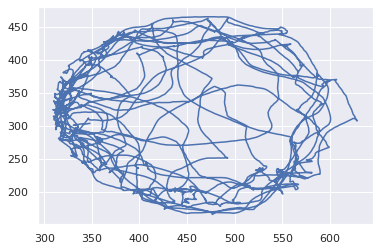

In [32]:
ID = 20
plt.plot(*df.query(f"ID == {ID}")[["x", "y"]].to_numpy().T)